This notebook prepares motivation letters as a dataframe, following these steps:
- txt files containing 5 letters each are split by letter, so that each letter
becomes their own entry in the dataframe
- model id is extracted from the filename
- profile id is extracted from the filename
- letter id is iteratively added to each dataframe entry depending on the position of the letter in the current split

Errors happen: some txt files cannot be split (e.g. they are not written in english or do not contain common delimiters between letters) resulting in a long entry containing all 5 letters

The dataframe is stored as "output.parquet".

Lastly some ngram statistics and visualizations are computed over the texts in the dataframe.

In [ ]:
import glob
import re

text_list = []
for filename in glob.glob("*.txt"):
    with open(filename, 'r') as f:
        text = f.read()
        # Determine delimiter based on filename
        if "llama-3-3-70b-versatile" in filename:
            delimiters = r'\n\n+|\r\n\r\n+'
        elif "gpt-4-1" in filename or "qwen" in filename:
            delimiters = r'---+'
        elif "gpt-4o" in filename:
            # Use "---" if it exists, otherwise use \n\n following "]"
            if re.search(r'---+', text):
                delimiters = r'---+'
            else:
                delimiters = r'\]\s*\n\n+'
        elif "kimi" in filename:
            delimiters = r'\n\n+'
        elif "o3" in filename:
            delimiters = r'\n\n\n+'
        else:
            # Default delimiter if no keyword is found
            delimiters = r'\n\n+|\r\n\r\n+|---+|Letter\s+[1-5]:?|\d+\.\s*|Letter\s+[1-5]'


        # Split the text using the delimiters
        parts = re.split(delimiters, text)
        # Remove any empty strings resulting from the split and append filename
        parts = [part.strip() + " " + filename for part in parts if part.strip()]
        # Ensure we have exactly 5 parts by padding with empty strings if necessary
        while len(parts) < 5:
            parts.append("")
        # Take the first 5 parts and extend the text_list
        text_list.extend(parts[:5])

print(text_list)

In [ ]:
import re

def extract_model_and_profile_id(filename):
    """
    Extracts the model name and profile ID from a filename string.

    Args:
        filename: The filename string in the format "<model>_<profile_id>.txt".

    Returns:
        A tuple containing the model name (string) and profile ID (integer),
        or (None, None) if the filename does not match the expected pattern.
    """
    # Define the regex pattern to capture the model and profile_id
    # It accounts for the possible model names and the integer profile_id, and the optional path
    pattern = r"^(?:.*/)?(gpt-4-1|gpt-4o|llama-3-3-70b-versatile|moonshotai-kimi-k2-instruct|o3|qwen-qwen3-32b)_(\d+)\.txt$"
    match = re.match(pattern, filename)

    if match:
        model = match.group(1)
        profile_id = int(match.group(2))
        return model, profile_id
    else:
        return None, None

# Example usage:
# filename1 = "gpt-4o_123.txt"
# model1, profile_id1 = extract_model_and_profile_id(filename1)
# print(f"Filename: {filename1}, Model: {model1}, Profile ID: {profile_id1}")

# filename2 = "llama-3-3-70b-versatile_999.txt"
# model2, profile_id2 = extract_model_and_profile_id(filename2)
# print(f"Filename: {filename2}, Model: {model2}, Profile ID: {profile_id2}")

# filename3 = "invalid_filename.txt"
# model3, profile_id3 = extract_model_and_profile_id(filename3)
# print(f"Filename: {filename3}, Model: {model3}, Profile ID: {profile_id3}")

In [ ]:
import pandas as pd
import glob

data = []
for filename in glob.glob("/content/credit/*.txt"):
    with open(filename, 'r') as f:
        text = f.read()

        # Determine delimiter based on filename
        if "llama-3-3-70b-versatile" in filename:
            delimiters = r'\n\n+|\r\n\r\n+'
        elif "gpt-4-1" in filename or "qwen" in filename:
            delimiters = r'---+'
        elif "gpt-4o" in filename:
            # Use "---" if it exists, otherwise use \n\n following "]"
            if re.search(r'---+', text):
                delimiters = r'---+'
            else:
                delimiters = r'\]\s*\n\n+'
        elif "kimi" in filename:
            delimiters = r'\n\n+'
        elif "o3" in filename:
            delimiters = r'\n\n\n+'
        else:
            # Default delimiter if no keyword is found
            delimiters = r'\n\n+|\r\n\r\n+|---+|Letter\s+[1-5]:?|\d+\.\s*|Letter\s+[1-5]'

        # Split the text using the delimiters
        parts = re.split(delimiters, text)
        # Remove any empty strings resulting from the split
        parts = [part.strip() for part in parts if part.strip()]

        # Ensure we have exactly 5 parts by padding with empty strings if necessary
        while len(parts) < 5:
            parts.append("")

        # Extract model and profile_id using the function
        model, profile_id = extract_model_and_profile_id(filename)

        # Create entries for the DataFrame
        for i, part in enumerate(parts[:5]):
            data.append({
                "model": model,
                "profile_id": profile_id,
                "letter_id": i + 1,
                "text": part
            })

df = pd.DataFrame(data)
display(df.head())

,model,profile_id,letter_id,text
0,o3,4,1,"Letter 1 \nFrankfurt, 12 September 2025 \n\n..."
1,o3,4,2,"Letter 2 \nMunich, 10 September 2025 \n\nDea..."
2,o3,4,3,"Letter 3 \nStuttgart, 8 September 2025 \n\nD..."
3,o3,4,4,"Letter 4 \nDresden, 11 September 2025 \n\nTo..."
4,o3,4,5,"Letter 5 \nHamburg, 9 September 2025 \n\nDea..."


In [ ]:
df.to_parquet("output.parquet")

In [ ]:
parquet_file_path = '/content/credit/output.parquet' # Assuming the file saved earlier is named output.parquet

try:
    df = pd.read_parquet(parquet_file_path)
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{parquet_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the parquet file: {e}")

,model,profile_id,letter_id,text
0,qwen-qwen3-32b,11,1,"<think>\nOkay, I need to write five motivation..."
1,qwen-qwen3-32b,11,2,"**Motivation Letter 2** \nDear Sir/Madam, \n..."
2,qwen-qwen3-32b,11,3,"**Motivation Letter 3** \nDear Sir/Madam, \n..."
3,qwen-qwen3-32b,11,4,"**Motivation Letter 4** \nDear Sir/Madam, \n..."
4,qwen-qwen3-32b,11,5,"**Motivation Letter 5** \nDear Sir/Madam, \n..."


2-2gram Histogram:
and have: 25155
have been: 22959
and am: 20648
checking account: 20046
in my: 18405
thank you: 17724
you for: 17183
for the: 16974
for my: 16293
loan of: 16089
my current: 15753
to purchase: 14375
year old: 14141
credit history: 14105
no other: 14016
have no: 13777
my application: 13700
for years: 13499
dm to: 13455
your bank: 13400


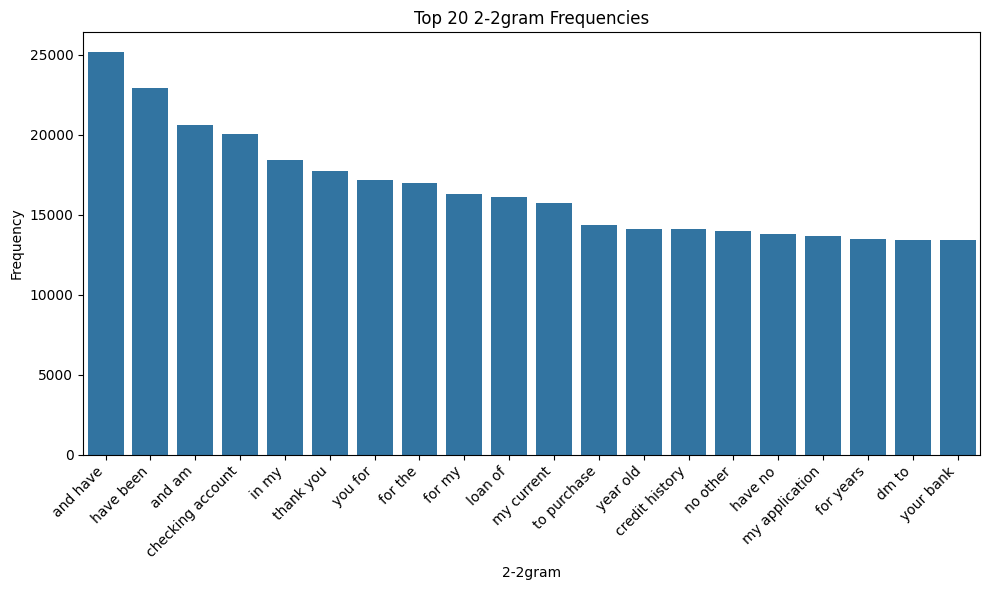

3-3gram Histogram:
thank you for: 17093
for the past: 11520
with your bank: 9464
for considering my: 8638
you for considering: 8546
have no other: 8538
am applying for: 8419
my name is: 8039
you for your: 7814
am committed to: 7408
my checking account: 7391
considering my application: 7317
dm to purchase: 7248
look forward to: 7098
am confident that: 7032
no other debts: 6884
am writing to: 6818
for loan of: 6539
to purchase new: 6427
my ability to: 5688


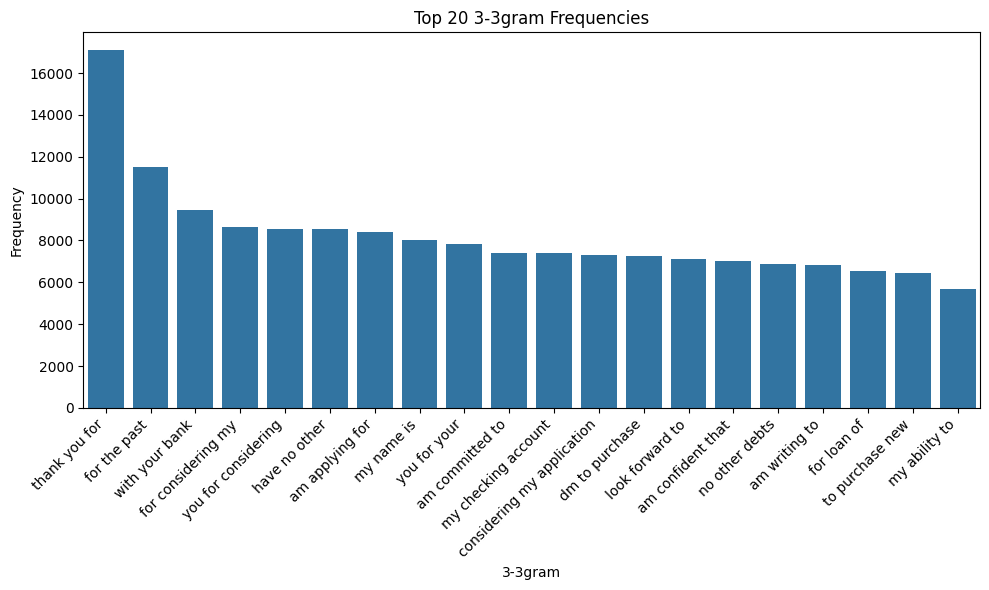

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and has a 'text' column
if 'df' in locals() and isinstance(df, pd.DataFrame) and 'text' in df.columns:
    corpus = df['text'].tolist()
else:
    # Keep the example corpus if df or 'text' column is not available
    corpus = [
        'This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
        'Is this the first document?',
    ]
    print("Warning: DataFrame 'df' with 'text' column not found. Using example corpus.")


def plot_ngram_histogram(corpus, ngram_range=(2, 2), top_n=10):
    """
    Calculates, prints, and visualizes the histogram of n-grams and their frequencies in a corpus.

    Args:
        corpus: A list of strings representing the corpus.
        ngram_range: The range of n-grams to consider (e.g., (1, 1) for unigrams, (2, 2) for bigrams).
        top_n: The number of top n-grams to display and visualize.
    """
    if not corpus:
        print("Corpus is empty. Cannot generate n-gram histogram.")
        return

    vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    frequencies = X.sum(axis=0).tolist()[0]

    # Create a dictionary of n-grams and their frequencies
    ngram_freq = dict(zip(ngrams, frequencies))

    # Sort the n-grams by frequency in descending order and take the top_n
    sorted_ngram_freq = dict(sorted(ngram_freq.items(), key=lambda item: item[1], reverse=True)[:top_n])

    print(f"{ngram_range[0]}-{ngram_range[1]}gram Histogram:")
    for ngram, freq in sorted_ngram_freq.items():
        print(f"{ngram}: {freq}")

    # Create a bar chart visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(sorted_ngram_freq.keys()), y=list(sorted_ngram_freq.values()))
    plt.title(f'Top {top_n} {ngram_range[0]}-{ngram_range[1]}gram Frequencies')
    plt.xlabel(f'{ngram_range[0]}-{ngram_range[1]}gram')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Example usage:
plot_ngram_histogram(corpus, ngram_range=(2, 2), top_n=20) # Example for bigrams
# plot_ngram_histogram(corpus, ngram_range=(1, 1), top_n=10) # Example for unigrams
plot_ngram_histogram(corpus, ngram_range=(3, 3), top_n=20) # Example for trigrams




# Task
Analyze and visualize the fractions of the most frequent n-grams per model from the 'text' column of the dataframe `df`, color-coding the histogram plot by model.

## Load the data

### Subtask:
Load the data from the parquet file into a DataFrame if it's not already loaded.


**Reasoning**:
Check if the dataframe `df` exists and has the 'text' column. If not, load the data from the parquet file.



In [ ]:
import pandas as pd

if 'df' not in locals() or not isinstance(df, pd.DataFrame) or 'text' not in df.columns:
    parquet_file_path = '/content/credit/output.parquet'
    try:
        df = pd.read_parquet(parquet_file_path)
        print(f"DataFrame loaded from {parquet_file_path}")
    except FileNotFoundError:
        print(f"Error: The file '{parquet_file_path}' was not found.")
        df = None # Ensure df is None if file not found
    except Exception as e:
        print(f"An error occurred while reading the parquet file: {e}")
        df = None # Ensure df is None if error occurs
else:
    print("DataFrame 'df' with 'text' column already exists.")

if df is not None:
    display(df.head())

DataFrame 'df' with 'text' column already exists.


,model,profile_id,letter_id,text
0,qwen-qwen3-32b,11,1,"<think>\nOkay, I need to write five motivation..."
1,qwen-qwen3-32b,11,2,"**Motivation Letter 2** \nDear Sir/Madam, \n..."
2,qwen-qwen3-32b,11,3,"**Motivation Letter 3** \nDear Sir/Madam, \n..."
3,qwen-qwen3-32b,11,4,"**Motivation Letter 4** \nDear Sir/Madam, \n..."
4,qwen-qwen3-32b,11,5,"**Motivation Letter 5** \nDear Sir/Madam, \n..."


## Define n-gram analysis function

### Subtask:
Create a function to calculate n-gram frequencies and fractions for a given text corpus.


**Reasoning**:
Define a function to calculate n-gram frequencies and fractions using CountVectorizer.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def calculate_ngram_fractions(corpus, n):
    """
    Calculates n-gram frequencies and fractions for a given text corpus.

    Args:
        corpus: A list of strings representing the corpus.
        n: The size of the n-grams (e.g., 1 for unigrams, 2 for bigrams).

    Returns:
        A pandas Series containing the n-grams and their calculated fractions,
        sorted in descending order of fraction.
    """
    if not corpus:
        return pd.Series()

    vectorizer = CountVectorizer(analyzer='word', ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    frequencies = X.sum(axis=0).tolist()[0]

    ngram_freq = dict(zip(ngrams, frequencies))

    total_ngrams = sum(frequencies)
    if total_ngrams == 0:
        return pd.Series()

    ngram_fractions = {ngram: freq / total_ngrams for ngram, freq in ngram_freq.items()}

    return pd.Series(ngram_fractions).sort_values(ascending=False)


## Group by model and analyze n-grams

### Subtask:
Group the DataFrame by the 'model' column and apply the n-gram analysis function to the text for each model.


**Reasoning**:
Group the DataFrame by 'model' and apply the n-gram analysis function to calculate n-gram fractions for each model.



In [ ]:
ngram_size = 2  # Define the desired n-gram size (e.g., 2 for bigrams)

# Group by 'model' and apply the n-gram analysis function
# Restructure the result to have model names as keys and Series of fractions as values
ngram_fractions_by_model_dict = {}
grouped_fractions = df.groupby('model')['text'].apply(lambda x: calculate_ngram_fractions(x.tolist(), ngram_size))

# Iterate through the multi-indexed Series and populate the dictionary
for (model, ngram), fraction in grouped_fractions.items():
    if model not in ngram_fractions_by_model_dict:
        ngram_fractions_by_model_dict[model] = {}
    ngram_fractions_by_model_dict[model][ngram] = fraction

# Convert the nested dictionary back to a dictionary of Series
ngram_fractions_by_model = {model: pd.Series(fractions).sort_values(ascending=False) for model, fractions in ngram_fractions_by_model_dict.items()}


# Display the results for each model (optional, for verification)
print(f"N-gram fractions for each model (ngram_size={ngram_size}):")
for model, fractions in ngram_fractions_by_model.items():
    print(f"\nModel: {model}")
    display(fractions.head()) # Display top n-grams for each model

N-gram fractions for each model (ngram_size=2):

Model: gpt-4-1


,0
and have,0.008053
loan of,0.005719
thank you,0.005602
have no,0.005421
for my,0.005363



Model: gpt-4o


,0
have been,0.007525
your name,0.007010
in my,0.006628
thank you,0.006448
you for,0.006427



Model: llama-3-3-70b-versatile


,0
and am,0.017300
have been,0.014517
and have,0.009928
the loan,0.008028
am confident,0.007518



Model: moonshotai-kimi-k2-instruct


,0
no other,0.005328
have no,0.004125
and my,0.004029
and have,0.003490
year old,0.003066



Model: o3


,0
your bank,0.004565
with your,0.003974
year old,0.003696
thank you,0.003217
you for,0.003194



Model: qwen-qwen3-32b


,0
for years,0.004970
checking account,0.004841
each letter,0.004679
foreign worker,0.003523
in my,0.003475


## Prepare data for plotting (Most Frequent N-grams)

### Subtask:
Structure the results from the n-gram analysis to include the most frequent n-grams for plotting.

**Reasoning**:
To visualize the most frequent n-grams, we need to select the top entries from the sorted n-gram fractions for each model and structure the data for plotting.

In [ ]:
# Select the top N n-grams from each model's results for plotting
top_n_plot = 30 # You can adjust the number of most frequent n-grams to plot
plot_data = []

for model, fractions in ngram_fractions_by_model.items():
    top_ngrams = fractions.head(top_n_plot)
    for ngram, fraction in top_ngrams.items():
        plot_data.append({
            'ngram': ngram,
            'fraction': fraction,
            'model': model
        })

plot_df = pd.DataFrame(plot_data)
display(plot_df.head())

,ngram,fraction,model
0,and have,0.008053,gpt-4-1
1,loan of,0.005719,gpt-4-1
2,thank you,0.005602,gpt-4-1
3,have no,0.005421,gpt-4-1
4,for my,0.005363,gpt-4-1


## Visualize the results (Most Frequent N-grams)

### Subtask:
Create a bar chart showing the fractions of the most frequent n-grams, color-coded by model.

**Reasoning**:
Use seaborn's `barplot` function to visualize the most frequent n-gram fractions, with 'ngram' on the x-axis, 'fraction' on the y-axis, and 'model' for color encoding.

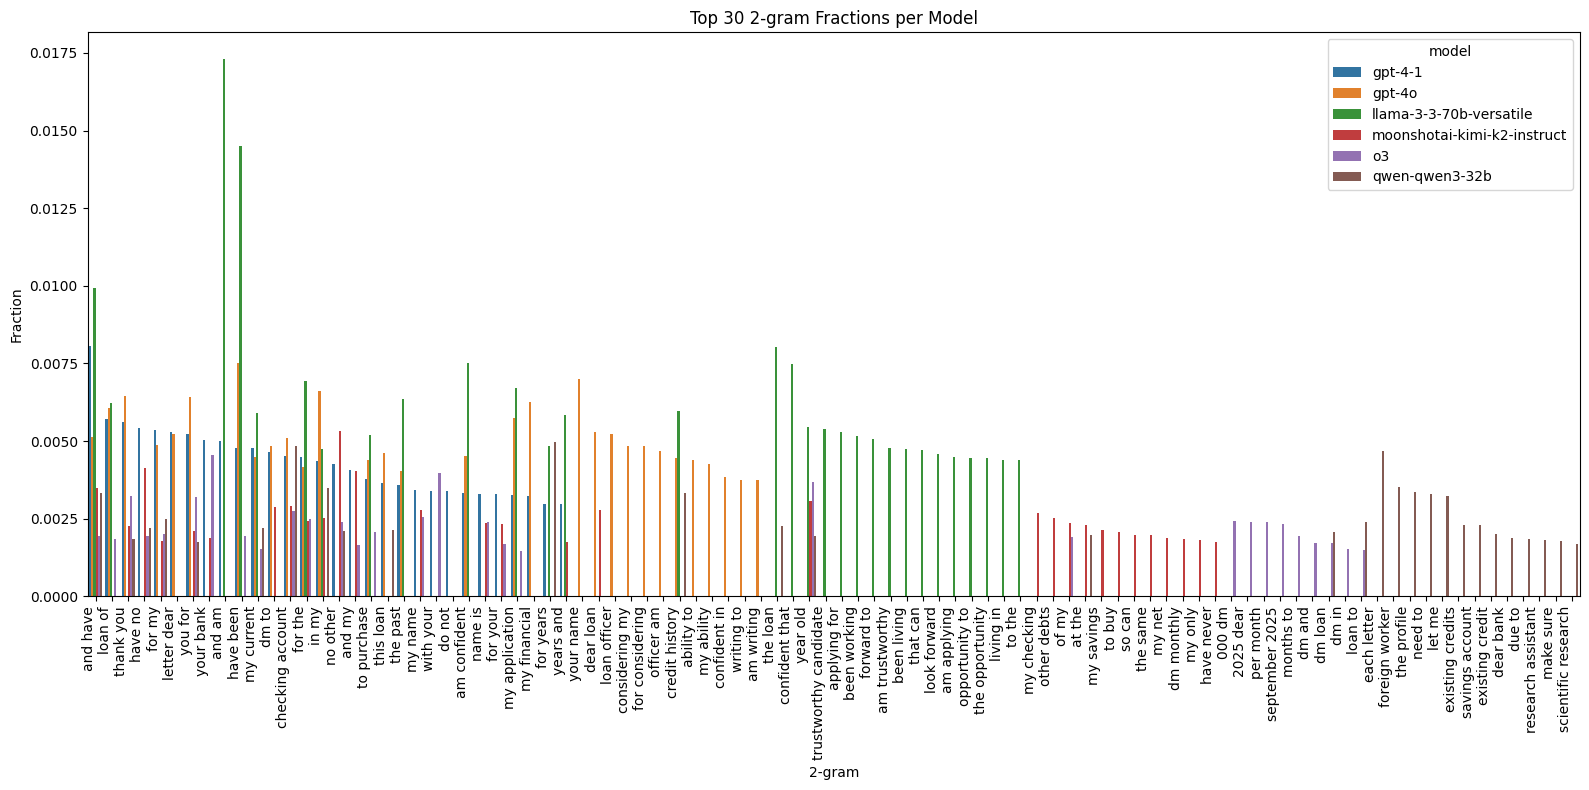

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.barplot(data=plot_df, x='ngram', y='fraction', hue='model')
plt.title(f'Top {top_n_plot} {ngram_size}-gram Fractions per Model')
plt.xlabel(f'{ngram_size}-gram')
plt.ylabel('Fraction')
plt.xticks(rotation=90, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

## Prepare data for plotting (Least Frequent N-grams)

### Subtask:
Structure the results from the n-gram analysis to include the least frequent n-grams for plotting.

**Reasoning**:
To visualize the least frequent n-grams, we need to select the bottom entries from the sorted n-gram fractions for each model and structure the data for plotting.

In [ ]:
# Select the bottom N n-grams from each model's results for plotting
bottom_n_plot = 10 # You can adjust the number of least frequent n-grams to plot
plot_data_least_frequent = []

for model, fractions in ngram_fractions_by_model.items():
    # Select the bottom n_grams by sorting in ascending order and taking the head
    bottom_ngrams = fractions.sort_values(ascending=True).head(bottom_n_plot)
    for ngram, fraction in bottom_ngrams.items():
        plot_data_least_frequent.append({
            'ngram': ngram,
            'fraction': fraction,
            'model': model
        })

plot_df_least_frequent = pd.DataFrame(plot_data_least_frequent)
display(plot_df_least_frequent.head())

,ngram,fraction,model
0,managing some,0.000001,gpt-4-1
1,managing store,0.000001,gpt-4-1
2,yusuf aydin,0.000001,gpt-4-1
3,yılmaz and,0.000001,gpt-4-1
4,zahnklinik müller,0.000001,gpt-4-1


## Visualize the results (Least Frequent N-grams)

### Subtask:
Create a bar chart showing the fractions of the least frequent n-grams, color-coded by model.

**Reasoning**:
Use seaborn's `barplot` function to visualize the least frequent n-gram fractions, with 'ngram' on the x-axis, 'fraction' on the y-axis, and 'model' for color encoding.

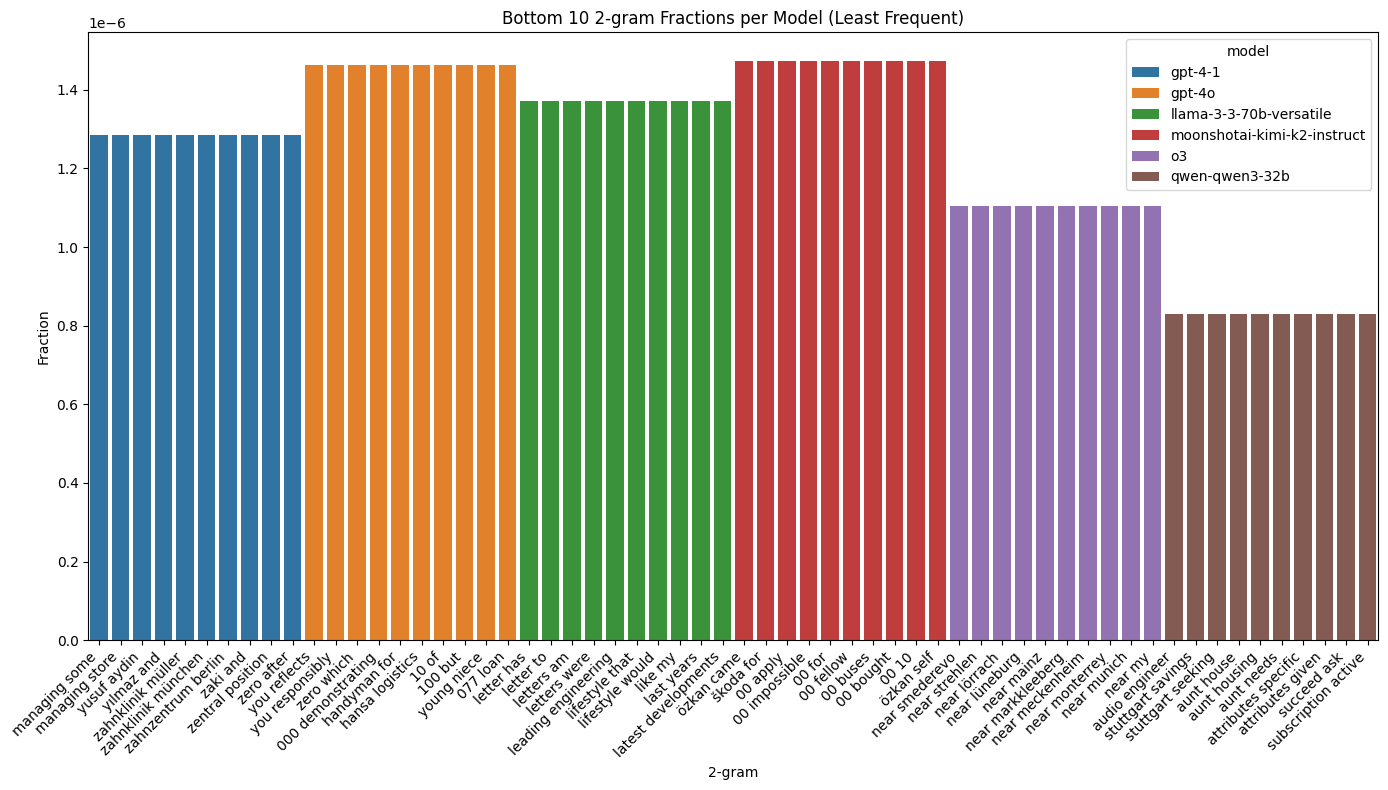

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.barplot(data=plot_df_least_frequent, x='ngram', y='fraction', hue='model')
plt.title(f'Bottom {bottom_n_plot} {ngram_size}-gram Fractions per Model (Least Frequent)')
plt.xlabel(f'{ngram_size}-gram')
plt.ylabel('Fraction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()